In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Dense, Dropout, Flatten
)
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from load_data import unpickle

In [2]:
plt.style.use('ggplot')

In [3]:
def get_filename(file_num):
    """Get the filename of a CIFAR-10 data batch
    
    Args:
        file_num (int): batch number
        
    Returns:
        filename (str): name of CIFAR-10 data batch
    """
    
    filename = 'data/data_batch_{0}'.format(file_num)
    return filename

def get_inputs(is_test_input=False):
    """Get the inputs from the CIFAR-10 data batches
    
    Args:
        is_test_input (bool): 
            specifies whether or not the inputs are test inputs
    
    Returns:
        X (numpy array): (N, 32, 32, 3) representation of images
        y (numpy array): one-hot encoded image labels
    """
    
    if (is_test_input):    
        batch = unpickle('data/test_batch')
        X, y = batch[b'data'], np.array(batch[b'labels'])
    else:
        files = [get_filename(file_num) for file_num in range(1, 6)]
        batches = [unpickle(file) for file in files]

        data = [batches[i][b'data'] for i in range(0, 5)]
        labels = [batches[i][b'labels'] for i in range(0, 5)]

        X, y = np.concatenate(data), np.concatenate(labels)
    
    X, y = X.reshape(X.shape[0], 32, 32, 3), to_categorical(y)
    X = X / 255
    return X, y

def epoch_data_to_df(history_dict, data_key, column_name):
    """Return a dataframe containing epoch data from a dictionary
    
    Args:
        history (dict): 
            contains training and validation data from the epochs
        data_key (str): 
            indicates the data to be put into the dataframe - accepts 
            'loss', 'val_loss', 'categorical_accuracy' or
            'val_categorical_accuracy'
        column_name (str): 
            column name for the data 
    
    Returns: 
        df (dataframe): contains 
    """
    
    data = history.history[data_key]
    num_epochs = len(data)
    df = pd.DataFrame({
        'epoch': np.arange(1, num_epochs + 1),
        column_name: data,
        'label': data_key
    })
    return df

In [4]:
X, y = get_inputs()
X_test, y_test = get_inputs(is_test_input=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [49]:
model = Sequential()
model.add(
    Conv2D(
        filters=32, 
        kernel_size=(3,3), 
        padding='same', 
        kernel_regularizer=regularizers.l2(0.0005), 
        input_shape=(32,32,3)
    )
)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', 
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', 
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', 
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding='same', 
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', 
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=10, activation="softmax"))

In [50]:
nadam_optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.001, 
    beta_1=0.9, 
    beta_2=0.999
)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=nadam_optimizer, 
    metrics=['categorical_accuracy']
)

In [51]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_52 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_53 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)       

In [52]:
num_epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train, 
    y_train, 
    batch_size=64,
    epochs=num_epochs, 
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 19s 465us/sample - loss: 2.1470 - categorical_accuracy: 0.3740 - val_loss: 1.7508 - val_categorical_accuracy: 0.4626
Epoch 2/100
40000/40000 [==============================] - 16s 401us/sample - loss: 1.6748 - categorical_accuracy: 0.4913 - val_loss: 1.5821 - val_categorical_accuracy: 0.5127
Epoch 3/100
40000/40000 [==============================] - 16s 405us/sample - loss: 1.4660 - categorical_accuracy: 0.5613 - val_loss: 1.4170 - val_categorical_accuracy: 0.5753
Epoch 4/100
40000/40000 [==============================] - 16s 407us/sample - loss: 1.3496 - categorical_accuracy: 0.6011 - val_loss: 1.3476 - val_categorical_accuracy: 0.5965
Epoch 5/100
40000/40000 [==============================] - 16s 408us/sample - loss: 1.2636 - categorical_accuracy: 0.6283 - val_loss: 1.2955 - val_categorical_accuracy: 0.6250
Epoch 6/100
40000/40000 [==============================] - 17s 416us/s

In [53]:
history_dict = history.history

training_loss = epoch_data_to_df(history_dict, 'loss', 'model_loss')
validation_loss = epoch_data_to_df(history_dict, 'val_loss', 'model_loss')
joint_loss = pd.concat([training_loss, validation_loss])
joint_loss.reset_index(inplace=True, drop=True)

training_accuracy = epoch_data_to_df(
    history_dict, 
    'categorical_accuracy', 
    'model_accuracy'
)
validation_accuracy = epoch_data_to_df(
    history_dict, 
    'val_categorical_accuracy', 
    'model_accuracy'
)
joint_accuracy = pd.concat([training_accuracy, validation_accuracy])
joint_accuracy.reset_index(inplace=True, drop=True)

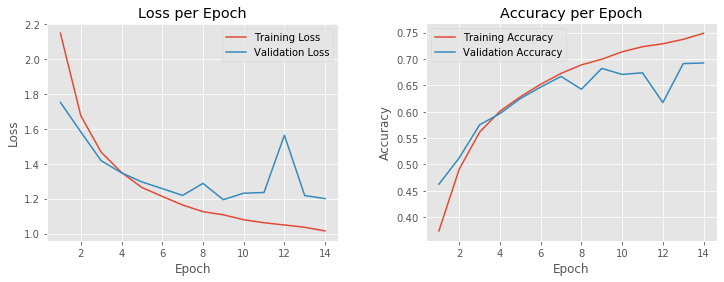

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes = axes.flatten()

loss_plot = sns.lineplot(
    x='epoch', 
    y='model_loss', 
    data=joint_loss,
    hue='label',
    ax=axes[0]
)
loss_plot.set(title="Loss per Epoch", xlabel="Epoch", ylabel="Loss")
loss_plot.legend(["Training Loss", "Validation Loss"])

accuracy_plot = sns.lineplot(
    x='epoch', 
    y='model_accuracy', 
    data=joint_accuracy,
    hue='label',
    ax=axes[1]
)
accuracy_plot.set(
    title="Accuracy per Epoch", 
    xlabel="Epoch", 
    ylabel="Accuracy"
)
accuracy_plot.legend(["Training Accuracy", "Validation Accuracy"])

plt.subplots_adjust(wspace=0.3)
plt.show()

In [55]:
scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.4f loss: %.4f' % (scores[1], scores[0]))

10000/10000 [==============================] - 1s 102us/sample - loss: 1.1738 - categorical_accuracy: 0.7059

Test result: 0.7059 loss: 1.1738
